In [1]:
naslib_path = '../../zero_cost/NASLib'
benchmark = 'zc_transbench101_micro'

In [2]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores


search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [3]:
dataset = 'class_scene'
proxy = 'nwot'
data = dfs[dataset]

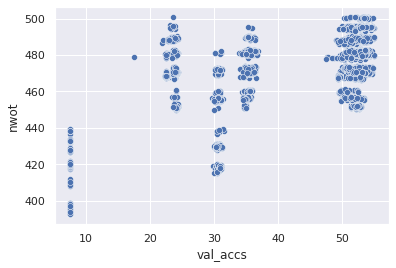

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

sns.scatterplot(data=data, x='val_accs', y=proxy)
#plt.xlim(70, 91)
#plt.ylim(-1, 300)
#plt_ylim(proxy)
plt.show()

In [5]:
from zc_combine.fixes.operations import parse_ops_nb201, count_all_ops

count_set = {0, 1, 2, 3}
ops = parse_ops_nb201(data)
count_all_ops(data, ops, count_set)

In [6]:
# TNB101_micro op names and edge indices to edges for convenience
# Op indices for zero and identity are 0, 1, in NB201 they are 1, 0
OP_NAMES = ["Zero", "Identity", "ReLUConvBN1x1", "ReLUConvBN3x3"]

EDGE_LIST = ((1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4))

## NASWOT bias
NASWOT seems to be highly biased towards the number of convolutions. Let us define `count` == number of `Conv3x3` + number of `Conv1x1` in a cell.

Then, plotting every count (from 1 to 6) as a different colour, we get this:

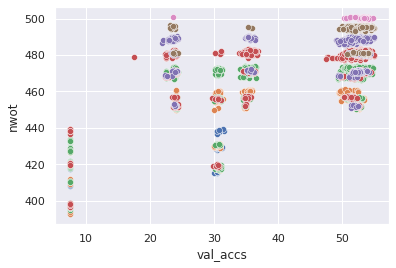

In [8]:
from zc_combine.fixes.operations import plot_clouds

plot_clouds(data, (2, 3), proxy, vmin=0, vmax=7)
#plt.ylim(-32.8, -31.8)
#plt_ylim(proxy)
plt.show()

In [8]:
data[data['val_accs'] > 93.5]

,net,val_accs,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,...,"(0, 2)","(0, 3)","(1, 2)","(1, 3)","(2, 3)","(0, 1, 2)","(0, 1, 3)","(0, 2, 3)","(1, 2, 3)","(0, 1, 2, 3)"
0,"(2, 3, 2, 3, 2, 3)",94.459282,0.003001,5598.380032,5.952258,-0.032183,-32.011262,1293.550415,506.305341,33.364817,...,3,3,3,3,6,3,3,6,6,6
1,"(3, 1, 1, 2, 1, 2)",94.158272,0.004510,2655.387648,4.823314,-0.227241,-32.011707,758.449158,491.568501,18.884177,...,2,1,5,4,3,5,4,3,6,6
3,"(3, 3, 3, 3, 0, 0)",94.211464,0.000473,6398.574592,4.503783,0.084207,-32.010905,856.408630,496.961579,37.090129,...,2,6,0,4,4,2,6,6,4,6
4,"(2, 1, 0, 1, 3, 0)",94.175423,0.003881,2737.405952,4.764160,-0.219613,-32.014236,659.693970,485.215071,19.749201,...,3,3,3,3,2,5,5,4,4,6
5,"(1, 0, 2, 0, 3, 1)",94.219162,0.012921,2736.259072,5.533641,-0.413092,-32.013751,581.215942,481.681018,19.747409,...,3,3,3,3,2,5,5,4,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4090,"(3, 3, 3, 1, 0, 2)",94.355728,0.001279,5308.743680,5.009158,0.058254,-32.009838,977.725891,497.376737,31.996497,...,2,4,2,4,4,3,5,5,5,6
4091,"(1, 3, 1, 2, 0, 3)",94.352173,0.000972,3997.564928,4.821770,-0.036306,-32.014897,758.240723,492.271118,25.699921,...,2,3,3,4,3,4,5,4,5,6
4092,"(2, 2, 2, 0, 3, 3)",94.031235,0.033937,4513.464320,8.157556,-0.280673,-32.019858,1095.707886,500.554640,28.616529,...,4,3,3,2,5,4,3,6,5,6
4094,"(3, 0, 1, 0, 2, 2)",94.405128,0.010115,2654.240768,5.692053,-0.196127,-32.013764,679.404358,489.054196,18.882385,...,4,3,3,2,3,5,4,5,4,6


In [9]:
data[data['val_accs'] < 92.5]

,net,val_accs,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,...,"(0, 2)","(0, 3)","(1, 2)","(1, 3)","(2, 3)","(0, 1, 2)","(0, 1, 3)","(0, 2, 3)","(1, 2, 3)","(0, 1, 2, 3)"
11,"(1, 0, 3, 2, 0, 0)",91.734161,2.818584e-03,2711.322624,4.423792,-0.257150,-3.223611e+01,560.429749,483.278618,19.575377,...,4,4,2,2,2,5,5,5,3,6
15,"(0, 0, 1, 0, 3, 3)",91.893562,1.479677e+09,4052.353024,4.401501,0.031332,-1.000000e+08,481.630432,396.728366,26.389329,...,3,5,1,3,2,4,6,5,3,6
18,"(2, 2, 0, 0, 1, 0)",91.777771,1.622006e-03,1318.125568,4.284376,0.088876,-3.230268e+01,439.806885,483.742008,12.413777,...,5,3,3,1,2,6,4,5,3,6
25,"(2, 2, 3, 2, 1, 0)",91.830490,1.802338e-02,2976.022528,4.952227,-0.317716,-3.224755e+01,856.702942,496.585593,20.771665,...,4,2,4,2,4,5,3,5,5,6
38,"(2, 0, 0, 0, 2, 2)",91.744148,1.527551e-02,1513.390080,6.314808,0.732705,-3.229657e+01,679.146729,482.348420,13.442897,...,6,3,3,0,3,6,3,6,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4038,"(2, 0, 2, 0, 1, 2)",91.709549,4.806228e-03,1513.390080,5.405909,-0.053472,-3.225170e+01,679.507385,489.176950,13.442897,...,5,2,4,1,3,6,3,5,4,6
4054,"(0, 0, 2, 0, 1, 0)",91.893562,1.346252e+09,1197.670400,4.459841,-0.164514,-1.000000e+08,263.138153,396.635696,11.900753,...,5,4,2,1,1,6,5,5,2,6
4059,"(0, 2, 0, 2, 1, 1)",91.770317,7.135354e-04,1318.125568,4.449774,0.245497,-3.241211e+01,440.270996,483.336236,12.413777,...,4,2,4,2,2,6,4,4,4,6
4061,"(0, 3, 3, 2, 3, 0)",91.823997,5.420146e-03,5483.986944,4.193664,0.091129,-3.235871e+01,876.940063,483.708859,33.198929,...,3,5,1,3,4,3,5,6,4,6


In [10]:
data[(data['val_accs'] > 92.5) & (data['val_accs'] < 93.5)]

,net,val_accs,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,...,"(0, 2)","(0, 3)","(1, 2)","(1, 3)","(2, 3)","(0, 1, 2)","(0, 1, 3)","(0, 2, 3)","(1, 2, 3)","(0, 1, 2, 3)"
2,"(0, 0, 2, 1, 2, 3)",92.932930,0.002168,2906.587136,4.426160,-0.264370,-32.082495,799.771118,459.612779,20.604497,...,4,3,3,2,3,5,4,5,4,6
13,"(0, 0, 0, 1, 1, 3)",92.872086,0.007068,2565.931008,4.328977,0.373825,-32.044579,363.107849,459.474204,18.890321,...,3,4,2,3,1,5,6,4,3,6
22,"(1, 2, 3, 1, 2, 0)",93.117432,0.000708,2907.734016,4.209169,-0.193518,-32.039762,878.529541,491.137256,20.606289,...,3,2,4,3,3,5,4,4,5,6
28,"(1, 0, 0, 1, 1, 3)",92.957588,0.000866,2592.014336,4.228532,-0.051795,-32.070980,462.926666,463.179152,19.064145,...,2,3,3,4,1,5,6,3,4,6
31,"(1, 2, 2, 1, 1, 2)",93.140732,0.000764,1565.556736,4.337433,-0.176999,-32.047228,879.443665,491.932303,13.790545,...,3,0,6,3,3,6,3,3,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4077,"(3, 0, 0, 1, 0, 3)",92.908997,0.005669,3852.173312,4.229303,0.094274,-32.084137,560.920288,474.757260,25.014865,...,3,5,1,3,2,4,6,5,3,6
4078,"(1, 0, 1, 2, 2, 0)",93.052727,0.001164,1369.145344,4.961405,-0.339179,-32.059959,560.666992,483.630154,12.759633,...,4,2,4,2,2,6,4,4,4,6
4079,"(1, 0, 1, 0, 2, 1)",93.098946,0.000973,1223.753728,4.390900,-0.343811,-32.049921,362.890259,471.911079,12.074577,...,3,2,4,3,1,6,5,3,4,6
4088,"(0, 0, 0, 1, 0, 3)",92.872086,0.006503,2565.931008,4.582037,-0.392395,-32.051617,362.522583,459.574717,18.890321,...,4,5,1,2,1,5,6,5,2,6


In [8]:
data[data['val_accs'] > 39]

,net,val_accs,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,zen,epe_nas,synflow,random,rank,"(2,)","(3,)","(2, 3)"
0,"(2, 3, 2, 3, 2, 3)",42.759754,4.458780,4662.880768,74.508804,-2.955261,-32.010446,1265.389038,500.717764,22.391940,0.066559,656.970154,140.918808,451.375314,108.596648,1196,1432.0,3,3,6
1,"(3, 1, 1, 2, 1, 2)",42.316879,0.685677,1719.888384,20.240038,-0.260801,-32.011969,730.687561,482.160494,7.911300,0.054861,179.962784,80.168358,838.104942,80.325202,2254,1945.0,2,1,3
3,"(3, 3, 3, 3, 0, 0)",42.411427,0.249479,5463.075328,6.833540,0.003300,-32.012307,828.335632,488.500280,26.117252,0.008881,57.221085,103.818619,823.921237,49.518576,3231,1861.0,0,4,4
4,"(2, 1, 0, 1, 3, 0)",42.804539,0.659891,1801.906688,15.660104,-0.071710,-32.032110,632.680176,472.649484,8.776324,0.042213,143.749313,62.030872,612.023126,78.312719,4089,1374.0,1,1,2
5,"(1, 0, 2, 0, 3, 1)",42.078026,0.533644,1800.759808,13.582209,-0.051730,-32.013104,552.923523,467.783782,8.774532,0.022371,127.051926,57.417717,481.159374,62.372724,2657,2143.5,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4090,"(3, 3, 3, 1, 0, 2)",44.153065,0.909518,4373.244416,30.881533,-0.187820,-32.012418,948.201050,489.694640,21.023620,0.055849,299.446136,113.669861,572.671152,117.801916,706,124.0,1,3,4
4091,"(1, 3, 1, 2, 0, 3)",42.819466,0.611565,3062.065664,21.564592,-0.168459,-32.011389,730.529236,482.606920,14.727044,-0.008370,193.672592,85.900841,741.089293,90.366001,1572,1353.5,1,2,3
4092,"(2, 2, 2, 0, 3, 3)",39.450638,6.198863,3577.965056,86.561401,-2.336487,-32.019332,1067.456665,493.603007,17.643652,0.045739,687.399597,109.258804,452.517163,107.955520,1633,2851.5,3,2,5
4094,"(3, 0, 1, 0, 2, 2)",41.197254,4.259406,1718.741504,43.316685,-1.310471,-32.011036,650.607178,478.166322,7.909508,0.018722,332.975159,65.601761,735.741729,85.261094,3021,2632.5,2,1,3


Let us zoom on a cloud, let's say `count` == 4 (red if plotting from `count` == 1).

Then, the clouds don't seem to depend on the number of `Conv3x3`.

But, accuracy seems to depend on it a bit!

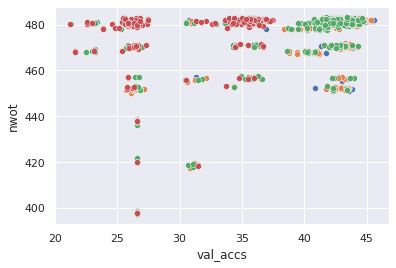

In [23]:
zoom = 3

data_zoom = data[data[str((2, 3))] == zoom]
plot_clouds(data_zoom, data_zoom[str((2,))], proxy, vmax=7)
#plt.xlim(69, 93)
#plt.ylim(700, 820)
plt.show()

Similar to NAS-Bench-201, there is some regularity in different score values:
- nets in the lowest cluster have inactive edges (1,2) and (1,3)
- nets in the second lowest cluster have inactive edge (1,2)
- nets in the second highest cluster have either inactive edge (1,2) and no other inactive, or have inactive both (1,3) and (1,4)
- nets in the highest cluster never have the highest edge inactive

In [42]:
import numpy as np
from zc_combine.fixes.operations import filter_by_range

def get_op_array(df):
    ops = parse_ops_nb201(df)
    return np.array(ops)

ops_0 = get_op_array(filter_by_range(data_zoom, proxy, 450, 465))
ops_1 = get_op_array(filter_by_range(data_zoom, proxy, 465, 475))
ops_2 = get_op_array(filter_by_range(data_zoom, proxy, 475, 483))
ops_3 = get_op_array(filter_by_range(data_zoom, proxy, 483, 500))

In [44]:
np.unique(ops_0[:, 0]), np.unique(ops_0[:, 1])

(array([0]), array([0]))

In [26]:
np.unique(ops_1[:, 0]), np.unique(ops_1[:, 1])

(array([0]), array([1, 2, 3]))

In [35]:
ops_2[ops_2[:, 0] != 0]

array([[3, 0, 0, 2, 3, 2],
       [2, 0, 0, 3, 2, 2],
       [3, 0, 0, 3, 3, 2],
       [3, 0, 0, 2, 3, 3],
       [2, 0, 0, 3, 3, 2],
       [2, 0, 0, 2, 2, 3],
       [2, 0, 0, 3, 2, 3],
       [3, 0, 0, 2, 2, 2],
       [2, 0, 0, 2, 2, 2],
       [2, 0, 0, 2, 3, 3],
       [3, 0, 0, 3, 3, 3],
       [2, 0, 0, 3, 3, 3],
       [2, 0, 0, 2, 3, 2],
       [3, 0, 0, 3, 2, 2],
       [3, 0, 0, 2, 2, 3],
       [3, 0, 0, 3, 2, 3]])

In [27]:
np.unique(ops_2[:, 0]), np.unique(ops_2[:, 1])

(array([0, 2, 3]), array([0, 2, 3]))

In [28]:
np.unique(ops_3[:, 0]), np.unique(ops_3[:, 1])

(array([1, 2, 3]), array([0, 1, 2, 3]))

## Conclusion
NASWOT score has problems on other datasets than CIFAR-10 as well.